In [1]:
# from SpiderMon import *
from matplotlib import pyplot as plt
from pprint import pprint
import os
from collections import Counter

if not os.path.abspath('.').endswith('netscope'):
    root_path = os.path.dirname(os.path.dirname(os.path.abspath('.')))
    os.chdir(root_path)
    from analysis.load import Loader
    
from SpiderMon import *

In [2]:
def rater(exp_kind, answer, contributors, topo):
    ans = answer[exp_kind][0]
    index = 0
    gt = ans['groundTruth']
    if exp_kind == "burst":
        flow_gt = f"{ans['src']}-{ans['dst']}"
        # ctrbts = [c.name for c in contributors]
        ctrb_df = pd.DataFrame(contributors).sort_values(['D', 'in_w'], ascending=False, ignore_index=True)
        ctrb = ctrb_df.name.tolist()
        if flow_gt in ctrb:
            index = ctrb.index(flow_gt) + 1
    elif exp_kind == "ecmp_imbalance":
        for idx, c in enumerate(contributors):
            src, dst = c.name.split('-')
            paths = topo.get_shortest_paths_between_nodes(src, dst)
            for p in paths:
                if gt in p:
                    index = idx
                    return index + 1
    elif exp_kind == "port_queue":
        ctrb_df = pd.DataFrame(contributors).sort_values(['D', 'in_w'], ascending=False, ignore_index=True)
        ctrb = ctrb_df.name.tolist()
        if gt in ctrb:
            return ctrb.index(gt) + 1
    return index

In [5]:
# log_folder = "/home/user/dds/netscope/experiment/data/slot2/s2l4/burst/"
log_folder = "/mnt/netscope/data/slot2/s2l4/ecmp_imbalance/"
# log_folder = "/mnt/netscope/data/slot2/s2l4/burst2/"
# log_folder = "/mnt/netscope/data/slot2/fattree4/burst/"
# log_folder = "/mnt/netscope/data/slot2/fattree4/ecmp_imbalance/"
# log_folder = "/mnt/netscope/data/slot2/fattree4/port_queue3/"
# log_folder = "/mnt/netscope/data/slot2/fattree4/delay/"

exp_ids = os.listdir(log_folder)
# exp_ids = ['20221005_1859GMT']

rca_result = []
for ie, exp_id in enumerate(exp_ids):
    print(ie, exp_id, end="...")
    log_dir = os.path.join(log_folder, exp_id)
    loader = Loader(log_dir)
    topo = loader.get_topo()
    hosts = loader.load_hosts(debug=True)
    hosts['flow'] = hosts['src'] + "-" + hosts["dst"]
    digests = loader.load_digest()
    
    with open(os.path.join(log_dir, 'answer.json'), 'r') as f:
        answer = json.load(f)
    exp_kind = list(answer.keys())[0]
    print(exp_kind, end="...")
    
    spidermon_report = hosts[
        (hosts.arrive_t <= max(digests.arrive_t)) &
        (hosts.arrive_t >= min(digests.arrive_t))].copy(deep=True)
    sw_dfs = load2df(spidermon_report, topo)
    
    if exp_kind in ['port_queue']:
        level = "port"
        if len(sw_dfs[sw_dfs.qdepth!=0]) == 0:
            sw_dfs = load2df(hosts, topo)
        
    else:
        level = "flow"
    
    wfg = WFG(sw_dfs, level)
    contributors = wfg.find_contributors()
    index = rater(exp_kind, answer, contributors, topo)
    print(index)
    
    rca_result.append(dict(
        id=exp_id,
        index=index,
        contributors=contributors,
        answer=answer,    
    ))
    # break

0 20221005_0935GMT...ecmp_imbalance...2
1 20221005_0951GMT...ecmp_imbalance...1
2 20221005_0955GMT...ecmp_imbalance...2
3 20221005_1000GMT...ecmp_imbalance...5
4 20221005_1042GMT...ecmp_imbalance...1
5 20221005_1047GMT...ecmp_imbalance...1
6 20221005_1052GMT...ecmp_imbalance...2
7 20221005_1054GMT...ecmp_imbalance...2
8 20221005_1109GMT...ecmp_imbalance...1
9 20221005_1131GMT...ecmp_imbalance...1
10 20221005_1133GMT...ecmp_imbalance...1
11 20221005_1146GMT...ecmp_imbalance...1
12 20221005_1148GMT...ecmp_imbalance...2
13 20221005_1153GMT...ecmp_imbalance...1
14 20221005_1156GMT...ecmp_imbalance...1
15 20221005_1200GMT...ecmp_imbalance...1
16 20221005_1203GMT...ecmp_imbalance...1
17 20221005_1210GMT...ecmp_imbalance...1
18 20221005_1213GMT...ecmp_imbalance...1
19 20221005_1225GMT...ecmp_imbalance...1
20 20221005_1227GMT...ecmp_imbalance...2
21 20221005_1237GMT...ecmp_imbalance...1
22 20221005_1239GMT...ecmp_imbalance...1
23 20221005_1244GMT...ecmp_imbalance...1


In [74]:
ans = answer[exp_kind][0]
ans

{'src': 'h1',
 'dst': 'h16',
 'paths': ['s7,s5,s1,s17,s20,',
  's7,s5,s2,s17,s20,',
  's7,s6,s3,s18,s20,',
  's7,s6,s4,s18,s20,'],
 'rate': 4,
 'port': 5,
 'inject_t': 45817858255486,
 'timeout': 25,
 'groundTruth': 's3,s18,',
 'abnormalKind': 'port queue rate'}

In [63]:
import itertools
if ',' not in ans['groundTruth']:
    victim_paths = ans['paths']
else:
    victim_paths = [p for p in ans['paths'] if ans['groundTruth'] in p]
victim_sws = [p.strip(',').split(',') for p in victim_paths]
victim_sws = sorted(set(itertools.chain(*victim_sws)))
victim_sws

['s18', 's19', 's3', 's6', 's7']

In [64]:
for sw in victim_sws:
    print(sw)
    sw_df = sw_dfs[sw_dfs.sw_id==sw]
    p_wfg_sw = WFG(sw_dfs, 'port')
    for p_ctr in p_wfg_sw.find_contributors():
        if p_ctr.D <= 0:
            break
        print(p_ctr)
    # break

s18
s19
s3
s6
s7


In [65]:
wfg_sw.find_contributors()

[Degree(name='s3,h1,', D=0, in_w=0, out_w=0),
 Degree(name='s5,s2,', D=0, in_w=0, out_w=0),
 Degree(name='s2,s6,', D=0, in_w=0, out_w=0),
 Degree(name='s6,h7,', D=0, in_w=0, out_w=0),
 Degree(name='s3,s1,', D=0, in_w=2, out_w=2),
 Degree(name='s1,s4,', D=0, in_w=0, out_w=0),
 Degree(name='s4,h4,', D=0, in_w=4296, out_w=4296),
 Degree(name='s5,h5,', D=0, in_w=11, out_w=11),
 Degree(name='s6,s2,', D=0, in_w=0, out_w=0),
 Degree(name='s2,s5,', D=0, in_w=0, out_w=0),
 Degree(name='s4,s2,', D=0, in_w=0, out_w=0),
 Degree(name='s5,s1,', D=0, in_w=0, out_w=0),
 Degree(name='s1,s6,', D=0, in_w=0, out_w=0),
 Degree(name='s3,s2,', D=0, in_w=2, out_w=2),
 Degree(name='s2,s4,', D=0, in_w=0, out_w=0),
 Degree(name='s6,s1,', D=0, in_w=0, out_w=0),
 Degree(name='s1,s5,', D=0, in_w=6, out_w=6),
 Degree(name='s4,s1,', D=0, in_w=0, out_w=0),
 Degree(name='s5,h6,', D=0, in_w=0, out_w=0)]

In [66]:
# markers = list('ov^<>12348sp*hH+xXDd|_.,')+[i for i in range(12)]
# fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(12, 4)) 
# for path, sdf in hosts.groupby('whole_path'):
#     sdf.plot('arrive_t', 'latency', ax=axes, label=path, alpha=0.3, lw=1, marker=markers[i], ls='')

# # plt.axvline()
# plt.axvspan(min(digests.arrive_t), max(digests.arrive_t), alpha=0.3)

In [6]:
def topk(k, counter):
    return sum([counter.get(i, 0) for i in range(1, k+1)])
rca_counts = Counter([r['index'] for r in rca_result])
print(rca_counts)
L = len(rca_result)

for k in [1, 2, 3, 5, 10]:
    tk = topk(k, rca_counts)
    print(f"top{k}: {tk}/{L} ({tk/L*100:.1f}%)")
    if tk == L: break

Counter({1: 17, 2: 6, 5: 1})
top1: 17/24 (70.8%)
top2: 23/24 (95.8%)
top3: 23/24 (95.8%)
top5: 24/24 (100.0%)


In [69]:
pd_code = 'dict(name="SpiderMon", '
for k in [1, 2, 3, 5, 10]:
    tk = topk(k, rca_counts)
    pd_code += f"t{k}={tk}/L, "
    if tk == L: break
pd_code = pd_code.rstrip(", ")+"),"
print(pd_code)

exam_score = 0
L_count = 0
for index, count in rca_counts.items():
    if index == 0: continue
    exam_score += (index - 1) * count
    L_count += count
print(exam_score, L_count, exam_score/L_count)

dict(name="SpiderMon", t1=1/L),
0 1 0.0


In [70]:

wfg = WFG(sw_dfs)
contributors = wfg.find_contributors()
# print(contributors)

# answer


# print(flow_gt)
index = rater(exp_kind, answer, contributors)
print(pd.DataFrame(contributors))
print(answer)

TypeError: rater() missing 1 required positional argument: 'topo'

In [ ]:
index

8

In [ ]:
for sw, sw_df in sw_dfs.groupby('sw_id'):
    if len(sw_df.qdepth.unique()) > 1:
        break
sw_df

,sw_id,ig_port,eg_port,state_i,state,timestamp,qdepth,packet_length,enq_timestamp,deq_timedelta,enq_qdepth,flow,flow_t,vertex
13,1,2,3,6,7,257507353484725,0,291,2589255471,78,0,h1-h4,257507353476803,h1-h4
22,1,3,2,6,7,257507353788197,0,365,2589558883,50188,0,h3-h2,257507353729294,h3-h2
25,1,2,3,6,7,257507353956124,0,291,2589725532,41,0,h1-h4,257507353952764,h1-h4
34,1,3,2,6,7,257507354232865,0,365,2590003217,72,0,h3-h2,257507354225252,h3-h2
38,1,2,3,6,7,257507354465061,0,291,2590234237,25,0,h1-h4,257507354457189,h1-h4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3204,1,5,4,6,7,257507401359258,0,304,2637128439,25,0,h8-h5,257507401349176,h8-h5
3201,1,4,5,6,7,257507401380835,0,320,2637150015,1645,0,h5-h7,257507401337352,h5-h7
3207,1,3,2,6,7,257507401502957,0,365,2637272155,26,0,h3-h2,257507401500148,h3-h2
3210,1,2,3,6,7,257507401534720,0,371,2637303902,24,0,h2-h4,257507401531944,h2-h4


In [ ]:
sw_df.qdepth.unique()

array([0, 1])

In [ ]:
w_df.sort_values('timestamp', ignore_index=True)

NameError: name 'w_df' is not defined

In [ ]:
sw_df.iloc[1975:2000]

,sw,qdepth,timestamp,flow,state,vertex


In [ ]:
len(sw_df)

638

In [ ]:
sw_df[sw_df.qdepth > 20]

,sw,qdepth,timestamp,flow,state,vertex
1975,2,21,257134587180265,h4-h8,7,h4-h8
1978,2,21,257134587276458,h1-h7,7,h1-h7
1990,2,21,257134587684366,h3-h7,7,h3-h7
1996,2,21,257134587856253,h1-h7,7,h1-h7
1999,2,21,257134587960274,h3-h7,7,h3-h7
2008,2,21,257134588258104,h3-h7,7,h3-h7
2014,2,22,257134588422791,h1-h7,7,h1-h7
2017,2,22,257134588527998,h3-h7,7,h3-h7
2026,2,22,257134588761872,h4-h8,7,h4-h8
2032,2,22,257134588972890,h3-h7,7,h3-h7


In [ ]:
dict(contributors[0][1]._asdict())

{'D': 0.0049172093174598645,
 'in_w': 0.00946266386291441,
 'out_w': 0.004545454545454545}

In [ ]:
sw_dfs.to_csv('vertex.csv', index=False)

In [ ]:
sw_dfs[sw_dfs.qdepth>0]

,sw,qdepth,timestamp,flow,vertex
216,4,1,254721567347573,h7-h3,h7-h3
238,4,1,254721567586248,h7-h3,h7-h3
257,4,1,254721567819588,h7-h3,h7-h3
292,4,1,254721568321498,h1-h3,h1-h3
320,4,1,254721568574408,h1-h3,h1-h3
...,...,...,...,...,...
4637,4,1,254721614263152,h1-h3,h1-h3
4668,4,1,254721614498162,h7-h3,h7-h3
4690,4,1,254721614749821,h7-h3,h7-h3
4712,4,1,254721614994027,h7-h3,h7-h3


In [ ]:
a

NameError: name 'a' is not defined

In [ ]:
data_path = '../../experiment/data/slot'
exp_kind = 'burst'
indexes = []
for i, exp_id in enumerate(sorted(os.listdir(os.path.join(data_path, exp_kind)))):
    print(exp_id)
    exp_path = os.path.join(data_path, exp_kind, exp_id)
    sw_dfs = load2df(exp_path)
    try:
        wfg = WFG(sw_dfs)
    except Exception as e:
        print(e)
        continue
    contributors = wfg.find_contributors()
    # print(contributors)
    
    # answer
    with open(os.path.join(exp_path, 'answer.json'), 'r') as f:
        answer = json.load(f)
        
    # print(flow_gt)
    index = rater(exp_kind, answer, contributors)
    indexes.append(index)
    # break
print(indexes)

20220831_0742GMT
20220831_0806GMT
20220831_0807GMT
20220831_0809GMT
20220831_0810GMT
20220831_0812GMT
20220831_0814GMT
20220831_0815GMT
20220831_0817GMT
20220831_0818GMT
20220831_0825GMT
20220831_0831GMT
20220831_0836GMT


KeyboardInterrupt: 

In [ ]:
sw_dfs

,sw,qdepth,timestamp,flow,vertex
0,3,0,254560254052851,h1-h3,h1-h3
1,1,0,254560254057984,h1-h3,h1-h3
2,4,0,254560254062261,h1-h3,h1-h3
3,3,0,254560254209244,h1-h3,h1-h3
4,1,0,254560254257900,h1-h3,h1-h3
...,...,...,...,...,...
2952,5,0,254560313317935,h7-h6,h7-h6
3161,1,0,254560313457802,h1-h3,h1-h3
3162,4,0,254560313474567,h1-h3,h1-h3
2965,5,0,254560313517920,h7-h6,h7-h6


In [ ]:
wfg.G.nodes

NodeView(('h1-h3', 'h2-h1', 'h3-h7', 'h4-h5', 'h5-h7', 'h6-h2', 'h7-h6', 'h8-h5'))

In [ ]:
[edge for edge in wfg.G.in_edges('h9-h16', data=True)]

[]

(array([1., 3., 2., 0., 0., 1., 3., 4.]),
 array([1.   , 1.875, 2.75 , 3.625, 4.5  , 5.375, 6.25 , 7.125, 8.   ]),
 <BarContainer object of 8 artists>)

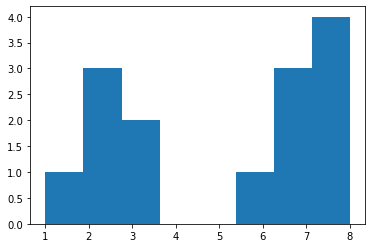

In [ ]:
plt.hist(indexes, bins=max(indexes))

In [ ]:
exp_path = 'data/20220619_0709GMT'
sw_dfs = load2df(exp_path)
wfg = WFG(sw_dfs)
contributors = wfg.find_contributors()
# print(contributors)

# answer
with open(os.path.join(exp_path, 'answer.json'), 'r') as f:
    answer = json.load(f)
    
# print(flow_gt)
index = rater(exp_kind, answer, contributors)
print(index)

FileNotFoundError: [Errno 2] No such file or directory: 'data/20220619_0709GMT/topology.json'

In [ ]:
index

1